In [1]:
import os
import cv2
import glob as gb
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator


os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

In [2]:
gpu_device = tf.config.experimental.list_physical_devices('GPU')
print(f"Number of GPU = {len(gpu_device)}")
tf.config.experimental.set_memory_growth(gpu_device[0], True)

Number of GPU = 1


In [3]:
SEED = 1000
IMG_SIZE = 224
BATCH_SIZE = 64

TRAIN_DIR = '../input/bird-species-classification-220-categories/Train'

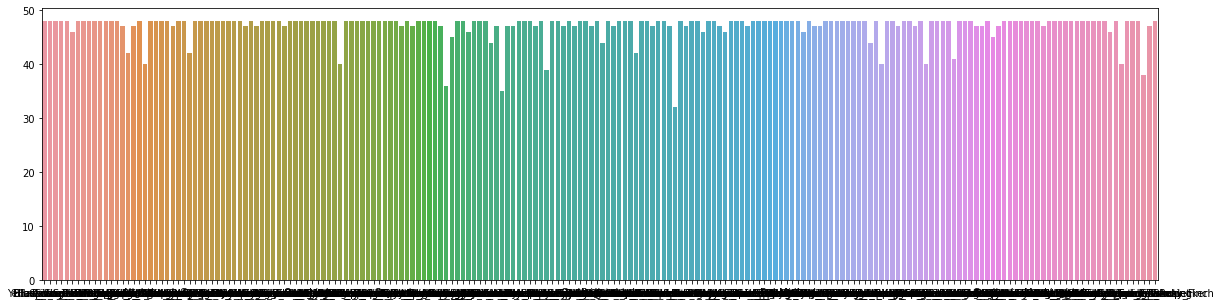

In [4]:
class_names = []
class_count = []
train_examples = 0
for f in os.listdir(TRAIN_DIR):
  files = gb.glob(pathname=str(TRAIN_DIR + "//" + f + "/*"))
  class_names.append(f)
  class_count.append(len(files))
  train_examples += len(files)
plt.figure(figsize=(20,5))
sns.barplot(x=class_names, y=class_count)
plt.show()

In [5]:
train_gen = ImageDataGenerator(
    rescale=1. / 255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.3
)

In [6]:
valid_batch = train_gen.flow_from_directory(
    directory=TRAIN_DIR,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    subset='validation',
    class_mode = 'categorical',
    seed=SEED
)

Found 2752 images belonging to 200 classes.


In [7]:
train_batch = train_gen.flow_from_directory(
    directory=TRAIN_DIR,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    subset='training',
    class_mode = 'categorical',
    seed=SEED
)

Found 6662 images belonging to 200 classes.


In [8]:
IMG_SHAPE = (IMG_SIZE,IMG_SIZE) + (3,)
base_model = tf.keras.applications.DenseNet121(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

29097984/29084464 [==============================] - 0s 0us/step


In [9]:
base_model.summary()

Model: "densenet121"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
zero_padding2d (ZeroPadding2D)  (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 112, 112, 64) 9408        zero_padding2d[0][0]             
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1/conv[0][0]                 
________________________________________________________________________________________

In [10]:
base_model.trainable = False

In [11]:
inputs = tf.keras.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
x = base_model(inputs, training=False)
x = tf.keras.layers.GlobalAveragePooling2D()(x)

x = tf.keras.layers.Dense(2048, activation='relu')(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Dropout(0.2)(x)

x = tf.keras.layers.Dense(2048, activation='relu')(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Dropout(0.2)(x)

x = tf.keras.layers.Dense(256, activation='relu')(x)
x = tf.keras.layers.BatchNormalization()(x)
# x = tf.keras.layers.Dropout(0.4)(x)


outputs = tf.keras.layers.Dense(200, activation='softmax')(x)
model = tf.keras.Model(inputs, outputs)

In [12]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
densenet121 (Functional)     (None, 7, 7, 1024)        7037504   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1024)              0         
_________________________________________________________________
dense (Dense)                (None, 2048)              2099200   
_________________________________________________________________
batch_normalization (BatchNo (None, 2048)              8192      
_________________________________________________________________
dropout (Dropout)            (None, 2048)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 2048)              419635

In [13]:
model.compile(
    loss='categorical_crossentropy',
#    optimizer=tf.keras.optimizers.RMSprop(lr=1e-4, momentum=0.9),
     optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3), 
#     loss='sparse_categorical_crossentropy', 
    metrics=['accuracy']
)

cb = tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0.02, patience=10, restore_best_weights=True)

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, min_lr=0.00001, verbose=1)


In [14]:
h = model.fit(train_batch, 
              epochs=100,
              steps_per_epoch = 6662  // BATCH_SIZE,
              validation_data = valid_batch,
              validation_steps = 2752 // BATCH_SIZE,
              callbacks=[cb, reduce_lr]
             )

Epoch 1/100
104/104 [==============================] - 204s 2s/step - loss: 3.4079 - accuracy: 0.2652 - val_loss: 2.7013 - val_accuracy: 0.3790
Epoch 2/100
104/104 [==============================] - 144s 1s/step - loss: 1.8115 - accuracy: 0.5565 - val_loss: 1.9625 - val_accuracy: 0.4956
Epoch 3/100
104/104 [==============================] - 143s 1s/step - loss: 1.3047 - accuracy: 0.6710 - val_loss: 2.0149 - val_accuracy: 0.4746
Epoch 4/100
104/104 [==============================] - 143s 1s/step - loss: 1.1065 - accuracy: 0.7120 - val_loss: 1.7833 - val_accuracy: 0.5167
Epoch 5/100
104/104 [==============================] - 144s 1s/step - loss: 0.8872 - accuracy: 0.7627 - val_loss: 1.8803 - val_accuracy: 0.5073
Epoch 6/100
104/104 [==============================] - 144s 1s/step - loss: 0.7512 - accuracy: 0.8002 - val_loss: 1.8500 - val_accuracy: 0.5236

Epoch 00006: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.
Epoch 7/100
104/104 [==============================] -

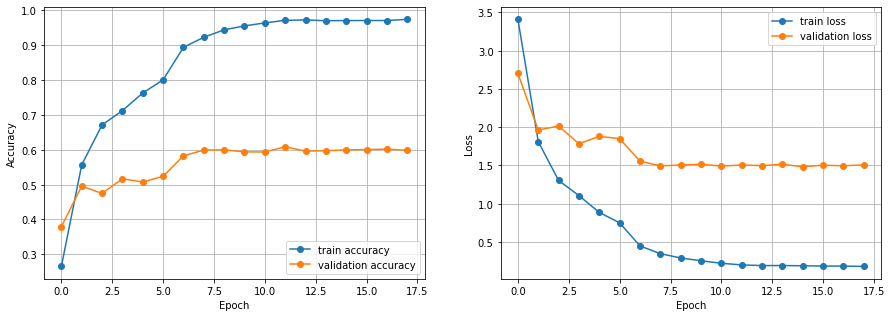

In [15]:
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.plot(h.history['accuracy'], 'o-', label='train accuracy')
plt.plot(h.history['val_accuracy'], 'o-', label = 'validation accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.grid(True)
plt.legend(loc='lower right')

plt.subplot(1,2,2)
plt.plot(h.history['loss'], 'o-', label='train loss')
plt.plot(h.history['val_loss'], 'o-', label='validation loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.legend(loc='upper right')
plt.savefig('DenseNet_with_Adam.pdf')
plt.show()